   T [min]     Butanal   butyroin  4,5-octanediol
0        0  235.403070   0.000000             0.0
1       15  136.667003  35.135764             0.0
2       30   78.775571  59.773672             0.0
3       60   39.501736  80.610846             0.0
4      140   15.373700  85.416647             0.0
0       0
1      15
2      30
3      60
4     140
5     155
6     170
7     203
8     440
9    1440
Name: T [min], dtype: int64


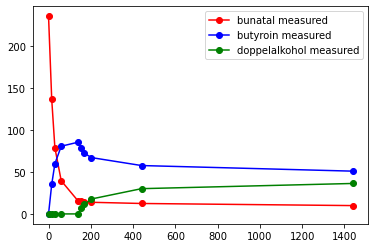

In [2]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"4,5-ODO Upscaling.xlsx")

print(df.head())


time = df["T [min]"]
substrate = df["Butanal"]
product = df["butyroin"]
product2 = df["4,5-octanediol"]

print(time)

fix, ax = plt.subplots()

ax.plot(time, substrate, label="bunatal measured", color="red", linestyle="-", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="-", marker="o")
ax.plot(time, product2, label="doppelalkohol measured", color="green", linestyle="-", marker="o")
ax.legend()

#plt.show()

[[235.40306997 136.66700304  78.77557135  39.50173584  15.37370005
   15.13829237  14.49406891  13.84240584  12.42792802   9.91667821]
 [  0.          35.13576358  59.77367168  80.61084579  85.41664722
   78.41427103  72.13699274  67.0658672   57.60108041  50.92454335]
 [  0.           0.           0.           0.           0.
    6.78494113  11.32583558  17.78875041  30.07338747  36.26918197]]
[240, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 30
    # variables        = 4
    chi-square         = 2614.33590
    reduced chi-square = 100.551381
    Akaike info crit   = 142.027040
    Bayesian info crit = 147.631830
[[Variables]]
    kA:  2.4595e-04 +/- 2.3019e-05 (9.36%) (init = 2)
    kP:  8.7198e-04 +/- 2.9530e-04 (33.87%) (init = 2)
    kC:  0.00867379 +/- 0.00312970 (36.08%) (init = 2)
    kD:  0.01453795 +/- 0.00695481 (47.84%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kC, kD) = 0.882
 

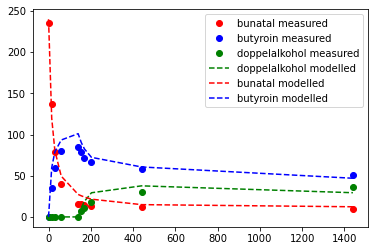

In [7]:
# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B
y0 = 100



data_list = [substrate, product, product2]

data = np.array(data_list)

print(data)


y0_array = [240, 0, 0]
print(y0_array)


def dbdt(kA, kB, kC, kD, A,P, C, t):
    if t <= 140:
        dbdt = (kA*A**2)*0.5 - kB*P
        return dbdt
    elif t >= 140:
        dbdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
        return dbdt
def dcdt(kC, kD, P, C, t):
    if t <= 140:
        return 0
    elif t >= 140:
        dcdt = kC*P - kD*C
        return dcdt



def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.00028, 0.000872, 0.0086, 0.014))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, substrate, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, product2, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")
plt.show()

In [34]:
# Extenden Model


time_reduced = [155, 170, 203, 440, 1440]
substrate_extended = np.array(substrate[5:])
product_extended = np.array(product[5:])
product2_extended = np.array(product2[5:])
data_list_extended = [substrate_extended, product_extended, product2_extended]
data_extended = np.array(data_list_reduced)

print(data_list_extended)

'''

def dglsys(init_cond_array, t, kA, kB):
    A = init_cond_array[0]
    P = init_cond_array[1]
    dAdt = -kA*A**2 + kB*P
    dBdt = (kA*A**2)*0.5 - kB*P
    dZdt = np.array([dAdt, dBdt])
    return dZdt

sol = odeint(dglsys, init_cond_reduced, time_reduced, args=(0.000245, 0.0024))

fig, ax = plt.subplots()
ax.plot(time_reduced, substrate_reduced, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time_reduced, product_reduced, label="butyroin measured", color="blue", linestyle="", marker="o")

params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    
    ymodel = odeint(dglsys, init_cond_reduced, time_reduced, args=(kA, kP))
    substr_red = data_reduced[0]-ymodel[:,0] # array 1
    product_red = data_reduced[1]-ymodel[:,1] # array 2
    result = [substr_red, product_red] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(time_reduced, data_reduced))
print(lmfit.report_fit(solution))


ax.plot(time_reduced, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time_reduced, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


print(time_reduced)
print(substrate_reduced)
print(product_reduced)

'''

[array([15.13829237, 14.49406891, 13.84240584, 12.42792802,  9.91667821]), array([78.41427103, 72.13699274, 67.0658672 , 57.60108041, 50.92454335]), array([ 6.78494113, 11.32583558, 17.78875041, 30.07338747, 36.26918197])]


'\n\ndef dglsys(init_cond_array, t, kA, kB):\n    A = init_cond_array[0]\n    P = init_cond_array[1]\n    dAdt = -kA*A**2 + kB*P\n    dBdt = (kA*A**2)*0.5 - kB*P\n    dZdt = np.array([dAdt, dBdt])\n    return dZdt\n\nsol = odeint(dglsys, init_cond_reduced, time_reduced, args=(0.000245, 0.0024))\n\nfig, ax = plt.subplots()\nax.plot(time_reduced, substrate_reduced, label="bunatal measured", color="red", linestyle="", marker="o")\nax.plot(time_reduced, product_reduced, label="butyroin measured", color="blue", linestyle="", marker="o")\n\nparams = lmfit.Parameters()\nparams.add(\'kA\', 2, min=0.00000001, max=3)\nparams.add(\'kP\', 2, min=0.0000000001, max=3)\n\ndef residual(params, time, data_sets):\n    kA = params[\'kA\'].value\n    kP = params[\'kP\'].value\n    \n    ymodel = odeint(dglsys, init_cond_reduced, time_reduced, args=(kA, kP))\n    substr_red = data_reduced[0]-ymodel[:,0] # array 1\n    product_red = data_reduced[1]-ymodel[:,1] # array 2\n    result = [substr_red, product_re

[[235.40306997 136.66700304  78.77557135  39.50173584  15.37370005
   15.13829237  14.49406891  13.84240584  12.42792802   9.91667821]
 [  0.          35.13576358  59.77367168  80.61084579  85.41664722
   78.41427103  72.13699274  67.0658672   57.60108041  50.92454335]
 [  0.           0.           0.           0.           0.
    6.78494113  11.32583558  17.78875041  30.07338747  36.26918197]]
[240, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 96
    # data points      = 30
    # variables        = 5
    chi-square         = 3730.83814
    reduced chi-square = 149.233525
    Akaike info crit   = 154.695724
    Bayesian info crit = 161.701711
[[Variables]]
    kA:   2.6850e-04 +/- 3.1903e-05 (11.88%) (init = 2)
    kP:   0.00109254 +/- 3.8332e-04 (35.09%) (init = 2)
    kC:   1.71596831 +/- 3.88285002 (226.28%) (init = 2)
    kD:   0.51954958 +/- 0.72761890 (140.05%) (init = 2)
    lag:  0.06955476 +/- 0.08004113 (115.08%) (init = 2)
[[Correlations

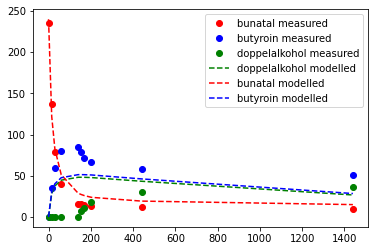

In [2]:

data_list = [substrate, product, product2]

data = np.array(data_list)

print(data)


y0_array = [240, 0, 0]
print(y0_array)

def dglsys(init_cond_array, t, kA, kB, kC, kD, lag):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    dBdt = (kA*A**2)*0.5 - kB*P - lag*kC*P + kD*C
    dCdt = lag*kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.00027, 0.002, 0.68, 2.9, 4))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)
params.add('lag', 2, min=0.0001, max=10)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    lag = params['lag'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD, lag))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, substrate, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, product2, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")

[[235.40306997 136.66700304  78.77557135  39.50173584  15.37370005
   15.13829237  14.49406891  13.84240584  12.42792802   9.91667821]
 [  0.          35.13576358  59.77367168  80.61084579  85.41664722
   78.41427103  72.13699274  67.0658672   57.60108041  50.92454335]
 [  0.           0.           0.           0.           0.
    6.78494113  11.32583558  17.78875041  30.07338747  36.26918197]]
[240, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 30
    # variables        = 4
    chi-square         = 2614.33590
    reduced chi-square = 100.551381
    Akaike info crit   = 142.027040
    Bayesian info crit = 147.631830
[[Variables]]
    kA:  2.4595e-04 +/- 2.3019e-05 (9.36%) (init = 2)
    kP:  8.7198e-04 +/- 2.9530e-04 (33.87%) (init = 2)
    kC:  0.00867379 +/- 0.00312970 (36.08%) (init = 2)
    kD:  0.01453795 +/- 0.00695481 (47.84%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kC, kD) = 0.882
 

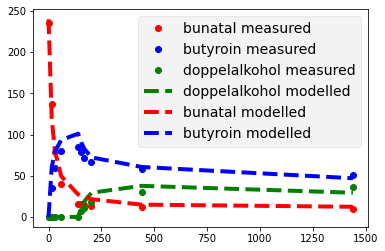

In [8]:
# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B
y0 = 100



data_list = [substrate, product, product2]

data = np.array(data_list)

print(data)


y0_array = [240, 0, 0]
print(y0_array)


def dbdt(kA, kB, kC, kD, A,P, C, t):
    if t <= 140:
        dbdt = (kA*A**2)*0.5 - kB*P
        return dbdt
    elif t >= 140:
        dbdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
        return dbdt
def dcdt(kC, kD, P, C, t):
    if t <= 140:
        return 0
    elif t >= 140:
        dcdt = kC*P - kD*C
        return dcdt



def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.00028, 0.000872, 0.0086, 0.014))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
ax.plot(time, substrate, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, product2, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")
plt.show()